In [1]:
import numpy as np
import saxsdocument
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
#from tensorflow.keras import regularizers
import DenseTranspose
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
%matplotlib notebook

In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mpl

# *Functions*

In [50]:
def chi2Loss(y_true, y_pred):
    chi2 = K.square(y_true - y_pred)/ y_true
    return chi2

def readFiles(path, folder, groundTruth = 'abs'):
    pathData = os.path.join(path, folder)
    pathAbs  = os.path.join(path, groundTruth)
    files = os.listdir(pathAbs)
    files.sort()
    IsA = []
    Is = []
    for f in files:
        # read abs
        p = os.path.join(pathAbs, f)
        cur, __ = saxsdocument.read(p)
        I = np.array(cur['I'])
        IsA.append(I)
        # read data
        f = f[:-4] + ".dat"
        p = os.path.join(pathData, f)
        cur, __ = saxsdocument.read(p)
        I = np.array(cur['I'])
        Is.append(I)
    print(f"{pathData}: {len(Is)} Data files <--> {len(IsA)} {groundTruth} files")
    return np.array(Is), np.array(IsA)

def predict_from_model(model, dataFolder, minimum, std, output, X, stdPDDF = None):
    files = os.listdir(dataFolder)
    files.sort()
    for inputFilename in files:
        path = os.path.join(dataFolder, inputFilename)
        #print(f"Reading: {path}")
        cur, __ = saxsdocument.read(path)
        s  = np.array(cur['s'])
        Is = np.array(cur['I'])
        # one way
        Is    = normalize(Is, std, minimum)
        test = np.array([Is, ])
        pred = model.predict(test)
        dat_decoded = pred[0]
        # or another
        if stdPDDF is not None: dat_decoded = unnormalize(dat_decoded, std, minimum) 
        else: dat_decoded = np.multiply(dat_decoded, stdPDDF) 
        dat_decoded = np.vstack((X, dat_decoded))
        np.savetxt(os.path.join(output, inputFilename), np.transpose(dat_decoded), fmt="%.8e")
        
def normalize(Is, std, minimum):
        Is    = np.abs(Is) + 0e-15
        Is    = np.log10(Is)
        Is    = np.divide(Is   , std)
        Is    = np.divide(Is   , minimum)
        where_are_NaNs = np.isnan(Is)
        Is[where_are_NaNs] = 0
        return Is
    
def unnormalize(Is, std, minimum):
        Is = Is * minimum
        Is = np.multiply(Is, std)
        Is = 10**Is
        return Is

# Read data and save

In [3]:
folders = ['dat-c025','dat-c05','dat-c1','dat-c2','dat-c4','dat-c8','dat-c16']
trainingFolder = "../7k-norm-i0/training"
validationFolder = "../7k-norm-i0/validation"
testFolder       = "../7k-norm-i0/test"
trainingIs           = []
validationIs         = []
testIs               = []

smoothTrainingIs     = []
smoothValidationIs   = []
smoothTestIs         = []

for f in folders:
    I, Ia = readFiles(trainingFolder, f)
    trainingIs.extend(I)
    smoothTrainingIs.extend(Ia)
    I, Ia = readFiles(validationFolder, f)
    validationIs.extend(I)
    smoothValidationIs.extend(Ia)
    I, Ia = readFiles(testFolder, f)
    testIs.extend(I)
    smoothTestIs.extend(Ia)



../7k-norm-i0/training\dat-c025: 5483 Data files <--> 5483 abs files
../7k-norm-i0/validation\dat-c025: 685 Data files <--> 685 abs files
../7k-norm-i0/test\dat-c025: 686 Data files <--> 686 abs files
../7k-norm-i0/training\dat-c05: 5483 Data files <--> 5483 abs files
../7k-norm-i0/validation\dat-c05: 685 Data files <--> 685 abs files
../7k-norm-i0/test\dat-c05: 686 Data files <--> 686 abs files
../7k-norm-i0/training\dat-c1: 5483 Data files <--> 5483 abs files
../7k-norm-i0/validation\dat-c1: 685 Data files <--> 685 abs files
../7k-norm-i0/test\dat-c1: 686 Data files <--> 686 abs files
../7k-norm-i0/training\dat-c2: 5483 Data files <--> 5483 abs files
../7k-norm-i0/validation\dat-c2: 685 Data files <--> 685 abs files
../7k-norm-i0/test\dat-c2: 686 Data files <--> 686 abs files
../7k-norm-i0/training\dat-c4: 5483 Data files <--> 5483 abs files
../7k-norm-i0/validation\dat-c4: 685 Data files <--> 685 abs files
../7k-norm-i0/test\dat-c4: 686 Data files <--> 686 abs files
../7k-norm-i0/tr

In [4]:
print(np.shape(trainingIs))
print(np.shape(smoothTrainingIs))
print(np.shape(validationIs))
print(np.shape(smoothValidationIs))
print(np.shape(testIs))
print(np.shape(smoothTestIs))

(38381, 256)
(38381, 256)
(4795, 256)
(4795, 256)
(4802, 256)
(4802, 256)


In [5]:
dataToSave = [trainingIs, validationIs, testIs, smoothTrainingIs, smoothValidationIs, smoothTestIs]
np.save('allData.npy', dataToSave)


In [6]:
# Load vars from file
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

allData = np.load('allData.npy')
trainingIs, validationIs, testIs, smoothTrainingIs, smoothValidationIs, smoothTestIs = allData

# restore np.load for future normal usage
np.load = np_load_old

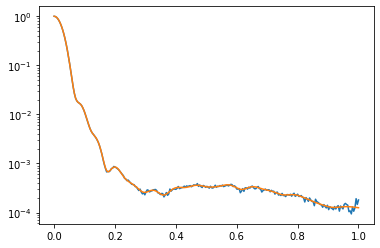

In [7]:
# save the s axis from the first smooth data file
d = "../7k-norm-i0/training/abs"
filesData = os.listdir(d)
firstFile = os.path.join(d, filesData[0])
cur, __ = saxsdocument.read(firstFile)
s = cur['s']

# So far so good:
plt.semilogy(s, trainingIs[38380])
plt.semilogy(s, smoothTrainingIs[38380])
#plt.semilogy(s, smoothTrainingIs[26900])

# Normalize data
[As described here](https://math.stackexchange.com/questions/2143062/how-to-normalize-this-exponentially-distributed-data/2143081)

In [8]:
# training
# make positive
ITr    = np.log10(trainingIs)
ITrS   = np.log10(smoothTrainingIs)
where_are_NaNs = np.isnan(ITr)
ITr[where_are_NaNs] = -5
where_are_NaNs = np.isnan(ITrS)
ITrS[where_are_NaNs] = -5

std       = np.std(ITr, axis = 0)
ITr       = np.divide(ITr   , std)
minimum   = np.min(ITr, axis = 0)
ITr       = np.divide(ITr   , minimum)

ITrS      = np.divide(ITrS   , std)
ITrS      = np.divide(ITrS   , minimum)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# validation
IVal    = np.log10(validationIs)
IValS    = np.log10(smoothValidationIs)
where_are_NaNs = np.isnan(IVal)
IVal[where_are_NaNs] = -5
where_are_NaNs = np.isnan(IValS)
IValS[where_are_NaNs] = -5
IVal    = np.divide(IVal   , std)
IVal    = np.divide(IVal   , minimum)

IValS   = np.divide(IValS   , std)
IValS   = np.divide(IValS   , minimum)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [10]:
# test
ITest    = np.log10(testIs)
where_are_NaNs = np.isnan(ITest)
ITest[where_are_NaNs] = -5
ITest    = np.divide(ITest   , std)
ITest    = np.divide(ITest   , minimum)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

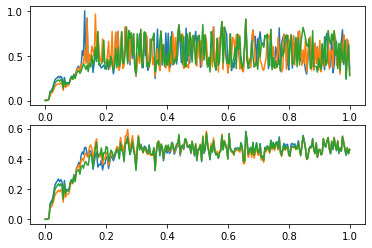

In [11]:
for i in range(1000, 1003, 1):
    plt.subplot(2,1,1)
    plt.plot(s, ITr[i])
    plt.subplot(2,1,2)
    plt.plot(s, ITrS[i])
plt.show()

# Make sure we still can restore the data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

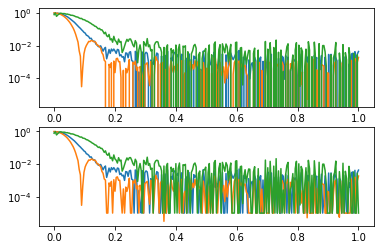

In [12]:
ITrRestored = unnormalize(ITr, std, minimum)

for i in range(10000, 10003, 1):
    plt.subplot(2,1,1)
    plt.semilogy(s, trainingIs[i])
    plt.subplot(2,1,2)
    #plt.semilogy(s, trainingIs[i])
    plt.semilogy(s, ITrRestored[i])
plt.show()

In [13]:
# Number of points in a SAXS curve
input_length  = np.shape(ITr)[1]
output_length = np.shape(ITr)[1]
# Functional API
inputs = keras.Input(shape=input_length)
x1 = Dense(input_length, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(inputs)
x2 = Dense(input_length, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x1)
x3 = Dense(input_length, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x2)
x4 = Dense(input_length, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x3)

outputs = Dense(input_length)(x4)

model = keras.Model(inputs=inputs, outputs=outputs, name='autoencoder')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [14]:
o = 'Adam'
l = 'huber_loss'
#l = 'categorical_crossentropy'
model.compile(optimizer=o, loss=l)
bs = 32
e = 20
train_history = model.fit(np.array(ITr), np.array(ITrS), epochs=e,  batch_size=bs,
                          validation_data =  (np.array(IVal), np.array(IValS)),callbacks=[ModelCheckpoint('auto.h5', save_best_only=True)])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 38381 samples, validate on 4795 samples
Epoch 1/20
38381/38381 [==============================] - 4s 103us/sample - loss: 6.9832e-04 - val_loss: 1.3575e-04
Epoch 2/20
38381/38381 [==============================] - 3s 65us/sample - loss: 1.0680e-04 - val_loss: 8.6054e-05
Epoch 3/20
38381/38381 [==============================] - 2s 62us/sample - loss: 8.1765e-05 - val_loss: 7.2774e-05
Epoch 4/20
38381/38381 [==============================] - ETA: 0s - loss: 7.3467e-0 - 2s 60us/sample - loss: 7.3392e-05 - val_loss: 6.3173e-05
Epoch 5/20
38381/38381 [==============================] - 2s 63us/sample - loss: 6.2826e-05 - val_loss: 5.6861e-05
Epoch 6/20
38381/38381 [==============================] - 2s 63us/sample - loss: 5.9921e-05 - val_loss: 5.2911e-05
Epoch 7/20
38381/38381 [==============================] - 2s 63us/sample - loss: 5.3961e-05 - val_loss: 5.5440e-05
Epoch 8/20
38381/38381 

In [15]:
model.load_weights('auto.h5')
o = optimizers.Adam(learning_rate = 0.00001)
l = 'huber_loss'
model.compile(optimizer=o, loss=l)
e = 20
train_history = model.fit(np.array(ITr), np.array(ITrS), epochs=e,  batch_size=bs,
                          validation_data =  (np.array(IVal), np.array(IValS)),callbacks=[ModelCheckpoint('auto.h5', save_best_only=True)])



Train on 38381 samples, validate on 4795 samples
Epoch 1/20
38381/38381 [==============================] - 2s 65us/sample - loss: 2.5651e-05 - val_loss: 2.8731e-05
Epoch 2/20
38381/38381 [==============================] - 2s 57us/sample - loss: 2.4985e-05 - val_loss: 2.8459e-05
Epoch 3/20
38381/38381 [==============================] - 2s 58us/sample - loss: 2.4809e-05 - val_loss: 2.8354e-05
Epoch 4/20
38381/38381 [==============================] - 2s 58us/sample - loss: 2.4660e-05 - val_loss: 2.8214e-05
Epoch 5/20
38381/38381 [==============================] - 2s 58us/sample - loss: 2.4573e-05 - val_loss: 2.8035e-05
Epoch 6/20
38381/38381 [==============================] - 2s 57us/sample - loss: 2.4473e-05 - val_loss: 2.8009e-05
Epoch 7/20
38381/38381 [==============================] - 2s 58us/sample - loss: 2.4408e-05 - val_loss: 2.7952e-05
Epoch 8/20
38381/38381 [==============================] - 2s 63us/sample - loss: 2.4349e-05 - val_loss: 2.7912e-05
Epoch 9/20
38381/38381 [=======

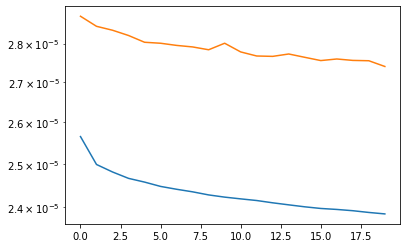

In [16]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.semilogy(range(e), loss)
plt.semilogy(range(e), val_loss)
plt.show()

In [19]:
testFolder       = "../7k-norm-i0/test"
for f in folders:
    p = os.path.join(testFolder, f)
    output = os.path.join("reconstruction", f)
    os.makedirs(output)
    predict_from_model(model, p, minimum, std, output, s)

## Pair distance distribution function
![Pair distance distribution function](pddf.png)

In [20]:
folders = ['dat-c025','dat-c05','dat-c1','dat-c2','dat-c4','dat-c8','dat-c16']
trainingFolder = "../7k-norm-i0/training"
validationFolder = "../7k-norm-i0/validation"
testFolder       = "../7k-norm-i0/test"
trainingIs           = []
validationIs         = []
testIs               = []

pddfTrainingIs     = []
pddfValidationIs   = []
pddfTestIs         = []

for f in folders:
    I, Ia = readFiles(trainingFolder, f, 'pddf')
    trainingIs.extend(I)
    pddfTrainingIs.extend(Ia)
    I, Ia = readFiles(validationFolder, f, 'pddf')
    validationIs.extend(I)
    pddfValidationIs.extend(Ia)
    I, Ia = readFiles(testFolder, f, 'pddf')
    testIs.extend(I)
    pddfTestIs.extend(Ia)

../7k-norm-i0/training\dat-c025: 5483 Data files <--> 5483 pddf files
../7k-norm-i0/validation\dat-c025: 685 Data files <--> 685 pddf files
../7k-norm-i0/test\dat-c025: 686 Data files <--> 686 pddf files
../7k-norm-i0/training\dat-c05: 5483 Data files <--> 5483 pddf files
../7k-norm-i0/validation\dat-c05: 685 Data files <--> 685 pddf files
../7k-norm-i0/test\dat-c05: 686 Data files <--> 686 pddf files
../7k-norm-i0/training\dat-c1: 5483 Data files <--> 5483 pddf files
../7k-norm-i0/validation\dat-c1: 685 Data files <--> 685 pddf files
../7k-norm-i0/test\dat-c1: 686 Data files <--> 686 pddf files
../7k-norm-i0/training\dat-c2: 5483 Data files <--> 5483 pddf files
../7k-norm-i0/validation\dat-c2: 685 Data files <--> 685 pddf files
../7k-norm-i0/test\dat-c2: 686 Data files <--> 686 pddf files
../7k-norm-i0/training\dat-c4: 5483 Data files <--> 5483 pddf files
../7k-norm-i0/validation\dat-c4: 685 Data files <--> 685 pddf files
../7k-norm-i0/test\dat-c4: 686 Data files <--> 686 pddf files
.

In [21]:
dataToSave = [trainingIs, validationIs, testIs, pddfTrainingIs, pddfValidationIs, pddfTestIs]
np.save('allDataPDDF.npy', dataToSave)

In [22]:
# Load vars from file
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

allData = np.load('allData.npy')
trainingIs, validationIs, testIs, pddfTrainingIs, pddfValidationIs, pddfTestIs = allData

# restore np.load for future normal usage
np.load = np_load_old

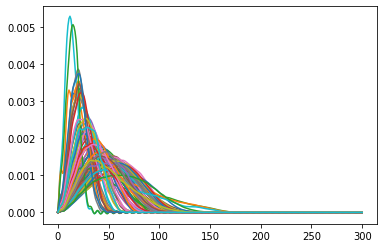

In [23]:
# save the s axis from the first smooth data file
d = "../7k-norm-i0/training/pddf"
filesData = os.listdir(d)
firstFile = os.path.join(d, filesData[0])
cur, __ = saxsdocument.read(firstFile)
r = cur['s']

# So far so good:
for i in range(100):
    plt.plot(r, pddfTrainingIs[i])


## Normalize

In [53]:
# training
# make positive
ITr    = np.log10(trainingIs)
where_are_NaNs = np.isnan(ITr)
ITr[where_are_NaNs] = -5

std       = np.std(ITr, axis = 0)
ITr       = np.divide(ITr   , std)
minimum   = np.min(ITr, axis = 0)
ITr       = np.divide(ITr   , minimum)

stdPDDF   = np.std(pddfTrainingIs, axis = 0)
ITrPDDF   = np.divide(pddfTrainingIs   , stdPDDF)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [39]:
# validation
# make positive
IVal    = np.log10(validationIs)
where_are_NaNs = np.isnan(IVal)
IVal[where_are_NaNs] = -5

IVal       = np.divide(IVal   , std)
IVal       = np.divide(IVal   , minimum)

IValPDDF   = np.divide(pddfValidationIs   , stdPDDF)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [40]:
# test
# make positive
ITest    = np.log10(testIs)
where_are_NaNs = np.isnan(ITest)
ITest[where_are_NaNs] = -5

ITest       = np.divide(ITest   , std)
ITest       = np.divide(ITest   , minimum)

ITestPDDF   = np.divide(pddfTestIs   , stdPDDF)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

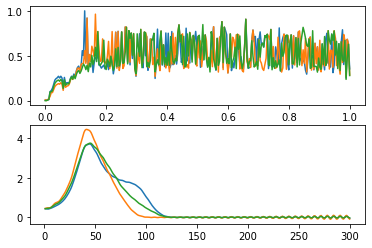

In [42]:
for i in range(1000, 1003, 1):
    plt.subplot(2,1,1)
    plt.plot(s, ITr[i])
    plt.subplot(2,1,2)
    plt.plot(r, ITrPDDF[i])
plt.show()

## Make sure we still can restore the data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currentl

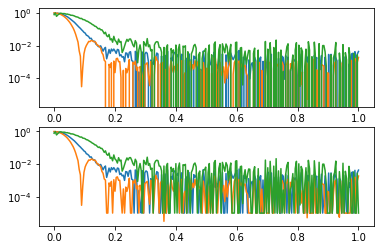

In [28]:
ITrRestored = unnormalize(ITr, std, minimum)

for i in range(10000, 10003, 1):
    plt.subplot(2,1,1)
    plt.semilogy(s, trainingIs[i])
    plt.subplot(2,1,2)
    #plt.semilogy(s, trainingIs[i])
    plt.semilogy(s, ITrRestored[i])
plt.show()

In [29]:
# Number of points in a SAXS curve
input_length  = np.shape(ITr)[1]
output_length = np.shape(pddfTrainingIs)[1]
# Functional API
inputs = keras.Input(shape=input_length)
x1 = Dense(input_length, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(inputs)
x2 = Dense(input_length, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x1)
x3 = Dense(input_length, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x2)
x4 = Dense(input_length, activation='relu', use_bias=True, kernel_initializer='glorot_uniform', bias_initializer='zeros')(x3)

outputs = Dense(output_length)(x4)

model = keras.Model(inputs=inputs, outputs=outputs, name='pddf-maker')

In [30]:
o = 'Adam'
l = 'huber_loss'
#l = 'categorical_crossentropy'
model.compile(optimizer=o, loss=l)
bs = 32
e = 20
train_history = model.fit(np.array(ITr), np.array(pddfTrainingIs), epochs=e,  batch_size=bs,
                          validation_data =  (np.array(IVal), np.array(pddfValidationIs)),callbacks=[ModelCheckpoint('pddf.h5', save_best_only=True)])



Train on 38381 samples, validate on 4795 samples
Epoch 1/20
38381/38381 [==============================] - 3s 73us/sample - loss: 1.2340e-05 - val_loss: 3.4533e-08
Epoch 2/20
38381/38381 [==============================] - 2s 64us/sample - loss: 3.4884e-08 - val_loss: 3.4360e-08
Epoch 3/20
38381/38381 [==============================] - 2s 60us/sample - loss: 3.5017e-08 - val_loss: 3.4485e-08
Epoch 4/20
38381/38381 [==============================] - 2s 60us/sample - loss: 3.5499e-08 - val_loss: 3.4810e-08
Epoch 5/20
38381/38381 [==============================] - 2s 62us/sample - loss: 3.5936e-08 - val_loss: 3.7009e-08
Epoch 6/20
38381/38381 [==============================] - 2s 62us/sample - loss: 3.6807e-08 - val_loss: 3.6939e-08
Epoch 7/20
38381/38381 [==============================] - 2s 63us/sample - loss: 3.7123e-08 - val_loss: 3.6349e-08
Epoch 8/20
38381/38381 [==============================] - 2s 61us/sample - loss: 3.7289e-08 - val_loss: 3.8743e-08
Epoch 9/20
38381/38381 [=======

In [31]:
model.load_weights('pddf.h5')
o = optimizers.Adam(learning_rate = 0.00001)
l = 'huber_loss'
model.compile(optimizer=o, loss=l)
e = 20
train_history = model.fit(np.array(ITr), np.array(pddfTrainingIs), epochs=e,  batch_size=bs,
                          validation_data =  (np.array(IVal), np.array(pddfValidationIs)),callbacks=[ModelCheckpoint('pddf.h5', save_best_only=True)])



Train on 38381 samples, validate on 4795 samples
Epoch 1/20
38381/38381 [==============================] - 3s 74us/sample - loss: 3.4345e-08 - val_loss: 3.3992e-08
Epoch 2/20
38381/38381 [==============================] - 2s 60us/sample - loss: 3.4336e-08 - val_loss: 3.4016e-08
Epoch 3/20
38381/38381 [==============================] - 2s 62us/sample - loss: 3.4333e-08 - val_loss: 3.4047e-08
Epoch 4/20
38381/38381 [==============================] - 2s 62us/sample - loss: 3.4339e-08 - val_loss: 3.4017e-08
Epoch 5/20
38381/38381 [==============================] - 3s 68us/sample - loss: 3.4325e-08 - val_loss: 3.3967e-08
Epoch 6/20
38381/38381 [==============================] - 2s 63us/sample - loss: 3.4319e-08 - val_loss: 3.3990e-08
Epoch 7/20
38381/38381 [==============================] - 2s 62us/sample - loss: 3.4320e-08 - val_loss: 3.3994e-08
Epoch 8/20
38381/38381 [==============================] - 2s 63us/sample - loss: 3.4307e-08 - val_loss: 3.4000e-08
Epoch 9/20
38381/38381 [=======

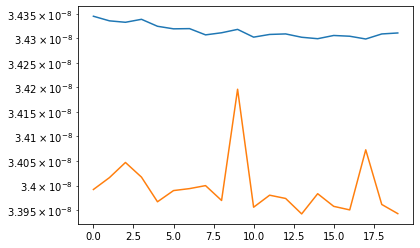

In [32]:
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']
plt.semilogy(range(e), loss)
plt.semilogy(range(e), val_loss)
plt.show()

In [54]:
testFolder       = "../7k-norm-i0/test"
for f in folders:
    p = os.path.join(testFolder, f)
    output = os.path.join("reconstruction-pddf", f)
    os.makedirs(output)

    predict_from_model(model, p, minimum, std, output, r, stdPDDF)

ValueError: operands could not be broadcast together with shapes (301,) (256,) 

In [56]:
print(f"{len(minimum)}, {len(std)}, {output}, {len(r)}, {len(stdPDDF)}")

256, 256, reconstruction-pddf\dat-c025, 301, 301
